In [7]:
%pip install duckdb pandas jupysql matplotlib --quiet


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Building Boilerplate below:
Using DuckDB will allows me to explore my Docker's LocalStack Gold Layer created.

In [8]:
import os 
import duckdb 

from dotenv import load_dotenv

load_dotenv()

conn = duckdb.connect()
conn.execute("INSTALL httpfs; LOAD httpfs;")
conn.execute(f"""
    SET s3_endpoint='{os.getenv("LOCALSTACK_ENDPOINT").replace("http://", "")}';
    SET s3_use_ssl=false;
    SET s3_url_style='path';
    SET s3_access_key_id='{os.getenv("AWS_ACCESS_KEY_ID")}';
    SET s3_secret_access_key='{os.getenv("AWS_SECRET_ACCESS_KEY")}';
    SET s3_region='{os.getenv("AWS_DEFAULT_REGION_ID")}';
""")

Using SQL to write my Star Schema Query

In [19]:
query = """
SELECT 
    c.coin_name, 
    f.price_usd, 
    d.hour,
    f.market_cap AS market_cap
FROM read_parquet('s3://crypto-raw-data/gold/fact_listings_*.parquet') f
JOIN read_parquet('s3://crypto-raw-data/gold/dim_coins_*.parquet') c ON f.coin_id = c.coin_id
JOIN read_parquet('s3://crypto-raw-data/gold/dim_date_*.parquet') d ON f.date_id = d.date_id
WHERE d.day = 6
ORDER BY f.price_usd DESC
LIMIT 100;
"""

df_results = conn.execute(query).df()
print(df_results)

                           coin_name     price_usd  hour    market_cap
0                 Maya Preferred PRA  6.483221e+08    15  0.000000e+00
1                 Maya Preferred PRA  6.483221e+08    15  0.000000e+00
2                        Jinbi Token  1.169220e+05    15  0.000000e+00
3                        Jinbi Token  1.169220e+05    15  0.000000e+00
4                            Bitcoin  9.419144e+04    15  1.881220e+12
..                               ...           ...   ...           ...
95     Intuit Tokenized Stock (Ondo)  6.447014e+02    15  1.366988e+06
96                      Bitcoin Cash  6.347484e+02    15  1.268049e+10
97                      Bitcoin Cash  6.347484e+02    15  1.268049e+10
98  Invesco QQQ Tokenized ETF (Ondo)  6.226785e+02    15  2.135344e+07
99  Invesco QQQ Tokenized ETF (Ondo)  6.226785e+02    15  2.135344e+07

[100 rows x 4 columns]


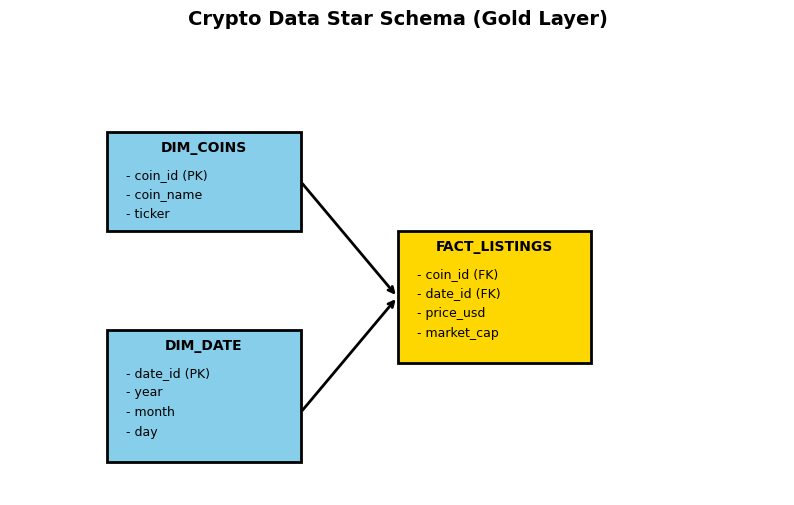

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def star_schema_design():
    fig, ax = plt.subplots(figsize=(10, 6))
    
    tables = {
        "fact_listings": [4, 2, 2, 2, "gold"],
        "dim_coins": [1, 4, 2, 1.5, "skyblue"],
        "dim_date": [1, 0.5, 2, 2, "skyblue"]
    }
    
    for name, (x, y, w, h, color) in tables.items():
        rect = mpatches.Rectangle((x, y), w, h, linewidth=2, edgecolor='black', facecolor=color)
        ax.add_patch(rect)
        plt.text(x + w/2, y + h - 0.3, name.upper(), weight='bold', ha='center')
        
        if "fact" in name:
            cols = ["coin_id (FK)", "date_id (FK)", "price_usd", "market_cap"]
        elif "coins" in name:
            cols = ["coin_id (PK)", "coin_name", "ticker"]
        else:
            cols = ["date_id (PK)", "year", "month", "day"]
            
        for i, col in enumerate(cols):
            plt.text(x + 0.2, y + h - 0.7 - (i * 0.3), f"- {col}", fontsize=9)

    ax.annotate('', xy=(4, 3), xytext=(3, 4.75), arrowprops=dict(arrowstyle='->', lw=2))
    ax.annotate('', xy=(4, 3), xytext=(3, 1.25), arrowprops=dict(arrowstyle='->', lw=2))

    plt.xlim(0, 8)
    plt.ylim(0, 7)
    plt.axis('off')
    plt.title("Crypto Data Star Schema (Gold Layer)", fontsize=14, weight='bold')
    plt.show()

star_schema_design()

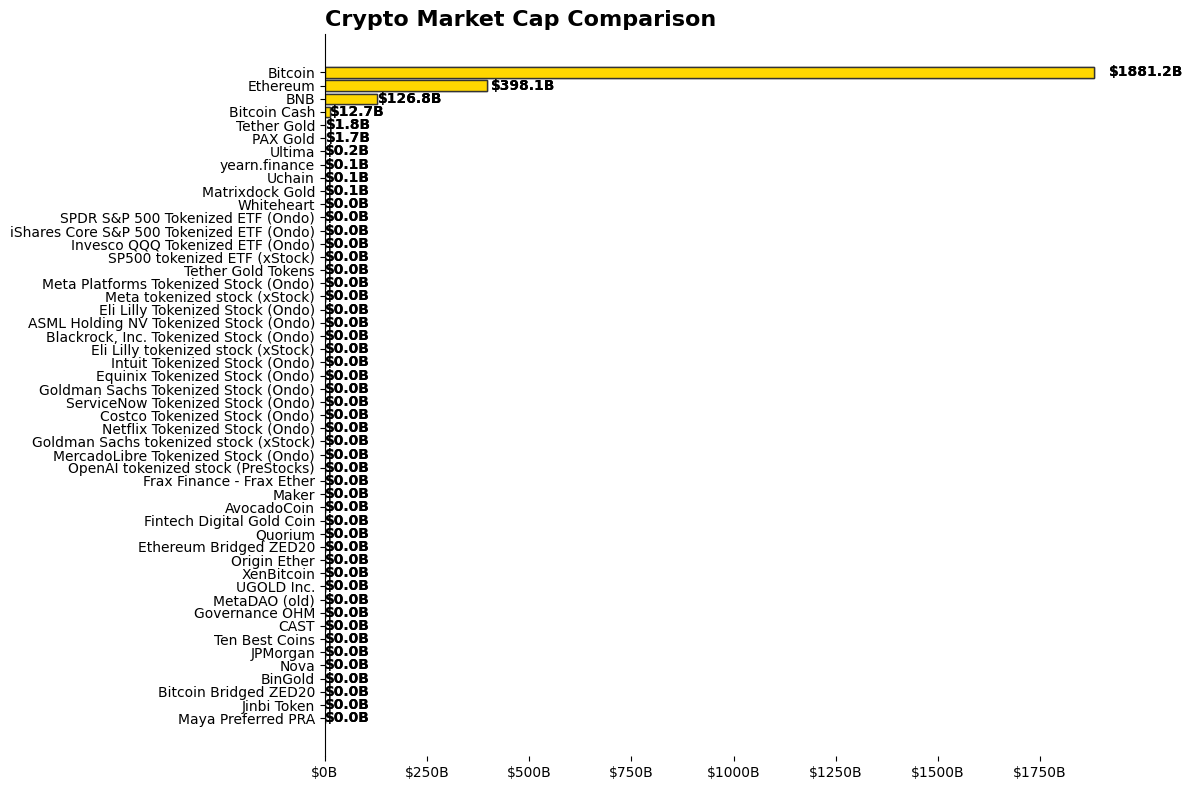

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

def plot_top_coins(df):
    plt.style.use('seaborn-v0_8-muted')
    fig, ax = plt.subplots(figsize=(12, 8))
    df = df.sort_values('market_cap', ascending=True)

    bars = ax.barh(df['coin_name'], df['market_cap'], color='#FFD700', edgecolor='#333333')
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${x*1e-9:.0f}B'))

    for bar in bars:
        width = bar.get_width()
        ax.text(width + (width*0.02), bar.get_y() + bar.get_height()/2,
                f'${width*1e-9:.1f}B', va='center', fontweight='bold')

    ax.set_title('Crypto Market Cap Comparison', fontsize=16, fontweight='bold', loc='left')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    plt.tight_layout()
    plt.show()

plot_top_coins(df_results)